# Tadpole data EDA and modeling
The aim of this notebook is to analyze the numerical data provided in the Tadpole challenge on ADNI using EDA and to use this data for predicting the different Alzheimer's classes. 

In the first part we do the EDA and preprocessing whereas in the second part we focus on using this data for modeling.


In [1]:
# Import all the required packages for data analysis and the EDA

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.model_selection import train_test_split
import os
import matplotlib.patches as mpatches

#Import packages for machine learning 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, precision_recall_curve
from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression



np.random.seed(42)

In [2]:
# Import packages to see models in MLFlow 
import logging
import parsenvy

from logging import getLogger
import mlflow
from config_tp import TRACKING_URI, EXPERIMENT_NAME
mlflow.set_tracking_uri(TRACKING_URI)
mlflow.set_experiment(EXPERIMENT_NAME)

<Experiment: artifact_location='s3://neuefische-mlflow/mlflow-artifacts/56', experiment_id='56', lifecycle_stage='active', name='alzbusters_numeric_models', tags={}>

In [3]:
# Enable viewing more of the columns 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)

In [4]:
#Set a color palette for the notebook 
sns.set_palette(palette='ch:start=.2,rot=-.3')

## 1. EDA and data pre-processing 

In [5]:
# Load the different datasets 
df_merge = pd.read_csv('../tadpole_challenge/ADNIMERGE.csv')
df_d1_d2 = pd.read_csv('../tadpole_challenge/TADPOLE_D1_D2.csv')
df_d3 = pd.read_csv('../tadpole_challenge/TADPOLE_D3.csv')
df_d4 = pd.read_csv('../tadpole_challenge/TADPOLE_D4_corr.csv')

/Users/tamarapallien/.pyenv/versions/3.9.8/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3553: DtypeWarning: Columns (18,19,20,103,104) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/tamarapallien/.pyenv/versions/3.9.8/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3553: DtypeWarning: Columns (471,473,474,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,569,570,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,599,601,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,624,625,626,627,628,629,630,631,632,633,634,636,637,638,639,640,641,642,643,644,645,646

In [6]:
# Let us find out the shape of the different datasets 
print([df_merge.shape, df_d1_d2.shape, df_d3.shape, df_d4.shape])

[(13915, 113), (12741, 1907), (896, 383), (234, 13)]


We can see here that the first dataframe has many entries and also quite a lot of columns (113). The second dataframe has almost 2000 columns, which might indicate that this one probably has a lot of information that we can not work with. For training a model the first dataframe looks quite suitable as it has many rows and a suitable amount of columns. The last one could be used as the test dataset. In the next parts we will  see if the columns from the first dataframe overlap with the last one. 

In [7]:
# Let us analyze the different datasets 
df_merge.head()

,RID,PTID,VISCODE,SITE,COLPROT,ORIGPROT,EXAMDATE,DX_bl,AGE,PTGENDER,PTEDUCAT,PTETHCAT,PTRACCAT,PTMARRY,APOE4,FDG,PIB,AV45,ABETA,TAU,PTAU,CDRSB,ADAS11,ADAS13,ADASQ4,MMSE,RAVLT_immediate,RAVLT_learning,RAVLT_forgetting,RAVLT_perc_forgetting,LDELTOTAL,DIGITSCOR,TRABSCOR,FAQ,MOCA,EcogPtMem,EcogPtLang,EcogPtVisspat,EcogPtPlan,EcogPtOrgan,EcogPtDivatt,EcogPtTotal,EcogSPMem,EcogSPLang,EcogSPVisspat,EcogSPPlan,EcogSPOrgan,EcogSPDivatt,EcogSPTotal,FLDSTRENG,FSVERSION,IMAGEUID,Ventricles,Hippocampus,WholeBrain,Entorhinal,Fusiform,MidTemp,ICV,DX,mPACCdigit,mPACCtrailsB,EXAMDATE_bl,CDRSB_bl,ADAS11_bl,ADAS13_bl,ADASQ4_bl,MMSE_bl,RAVLT_immediate_bl,RAVLT_learning_bl,RAVLT_forgetting_bl,RAVLT_perc_forgetting_bl,LDELTOTAL_BL,DIGITSCOR_bl,TRABSCOR_bl,FAQ_bl,mPACCdigit_bl,mPACCtrailsB_bl,FLDSTRENG_bl,FSVERSION_bl,Ventricles_bl,Hippocampus_bl,WholeBrain_bl,Entorhinal_bl,Fusiform_bl,MidTemp_bl,ICV_bl,MOCA_bl,EcogPtMem_bl,EcogPtLang_bl,EcogPtVisspat_bl,EcogPtPlan_bl,EcogPtOrgan_bl,EcogPtDivatt_bl,EcogPtTotal_bl,EcogSPMem_bl,EcogSPLang_bl,EcogSPVisspat_bl,EcogSPPlan_bl,EcogSPOrgan_bl,EcogSPDivatt_bl,EcogSPTotal_bl,ABETA_bl,TAU_bl,PTAU_bl,FDG_bl,PIB_bl,AV45_bl,Years_bl,Month_bl,Month,M,update_stamp
0,2,011_S_0002,bl,11,ADNI1,ADNI1,2005-09-08,CN,74.3,Male,16,Not Hisp/Latino,White,Married,0.0,1.36665,NaN,NaN,NaN,NaN,NaN,0.0,10.67,18.67,5.0,28.0,44.0,4.0,6.0,54.5455,10.0,34.0,112.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.5 Tesla MRI,Cross-Sectional FreeSurfer (FreeSurfer Version...,35475.0,118233.0,8336.0,1229740.0,4177.0,16559.0,27936.0,1984660.0,CN,-4.37389,-4.17931,2005-09-08,0.0,10.67,18.67,5.0,28,44.0,4.0,6.0,54.5455,10.0,34.0,112.0,0.0,-4.37389,-4.17931,1.5 Tesla MRI,Cross-Sectional FreeSurfer (FreeSurfer Version...,118233.0,8336.0,1229740.0,4177.0,16559.0,27936.0,1984660.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.36665,NaN,NaN,0.000000,0.00000,0,0,2019-02-14 23:58:27.0
1,3,011_S_0003,bl,11,ADNI1,ADNI1,2005-09-12,AD,81.3,Male,18,Not Hisp/Latino,White,Married,1.0,1.08355,NaN,NaN,741.5,239.7,22.83,4.5,22.00,31.00,8.0,20.0,22.0,1.0,4.0,100.0000,2.0,25.0,148.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.5 Tesla MRI,Cross-Sectional FreeSurfer (FreeSurfer Version...,32237.0,84599.0,5319.0,1129830.0,1791.0,15506.0,18422.0,1920690.0,Dementia,-16.61980,-16.20680,2005-09-12,4.5,22.00,31.00,8.0,20,22.0,1.0,4.0,100.0000,2.0,25.0,148.0,10.0,-16.61980,-16.20680,1.5 Tesla MRI,Cross-Sectional FreeSurfer (FreeSurfer Version...,84599.0,5319.0,1129830.0,1791.0,15506.0,18422.0,1920690.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,741.5,239.7,22.83,1.08355,NaN,NaN,0.000000,0.00000,0,0,2019-02-14 23:58:27.0
2,3,011_S_0003,m06,11,ADNI1,ADNI1,2006-03-13,AD,81.3,Male,18,Not Hisp/Latino,White,Married,1.0,1.05803,NaN,NaN,NaN,NaN,NaN,6.0,19.00,30.00,10.0,24.0,19.0,2.0,6.0,100.0000,NaN,19.0,135.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.5 Tesla MRI,Cross-Sectional FreeSurfer (FreeSurfer Version...,31863.0,88580.0,5446.0,1100060.0,2427.0,14400.0,16972.0,1906430.0,Dementia,-15.04880,-13.42180,2005-09-12,4.5,22.00,31.00,8.0,20,22.0,1.0,4.0,100.0000,2.0,25.0,148.0,10.0,-16.61980,-16.20680,1.5 Tesla MRI,Cross-Sectional FreeSurfer (FreeSurfer Version...,84599.0,5319.0,1129830.0,1791.0,15506.0,18422.0,1920690.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,741.5,239.7,22.83,1.08355,NaN,NaN,0.498289,5.96721,6,6,2019-02-14 23:58:27.0
3,3,011_S_0003,m12,11,ADNI1,ADNI1,2006-09-12,AD,81.3,Male,18,Not Hisp/Latino,White,Married,1.0,1.09690,NaN,NaN,601.4,251.7,24.18,3.5,24.00,35.00,10.0,17.0,31.0,2.0,7.0,100.0000,0.0,21.0,126.0,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.5 Tesla MRI,Cross-Sectional FreeSurfer (FreeSurfer Version...,35576.0,90099.0,5157.0,1095640.0,1596.0,14617.0,17330.0,1903820.0,Dementia,-21.46000,-20.27140,2005-09-12,4.5,22.00,31.00,8.0,20,22.0,1.0,4.0,100.0000,2.0,25.0,148.0,10.0,-16.61980,-16.20680,1.5 Tesla MR

From this website (https://tadpole.grand-challenge.org/FAQ/) we got some more information about what the columns actually mean. The Column DX is the clinical diagnosis. The DX_bl column contains the diagnosis at the first visit. The column RID contains the unique identifying code for the subject. EXAMDATE labels the date at which the subject visiting the clinic and the data was aquired. The APOE4 is the strongest risk factor gene for Alzheimers. 
What we further can see is that the subjects have been investigated more than once. We only want to have each patient only once in our dataset. So this is why we set month to 0. 

In [8]:
# Remove all the duplicate entries for the patients and only use the first visit.
df=df_merge.query('Month==0')
df.shape

(2155, 113)

In [9]:
df.info(verbose=True, show_counts=True)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2155 entries, 0 to 13911
Data columns (total 113 columns):
 #    Column                    Non-Null Count  Dtype  
---   ------                    --------------  -----  
 0    RID                       2155 non-null   int64  
 1    PTID                      2155 non-null   object 
 2    VISCODE                   2155 non-null   object 
 3    SITE                      2155 non-null   int64  
 4    COLPROT                   2155 non-null   object 
 5    ORIGPROT                  2155 non-null   object 
 6    EXAMDATE                  2155 non-null   object 
 7    DX_bl                     2132 non-null   object 
 8    AGE                       2153 non-null   float64
 9    PTGENDER                  2155 non-null   object 
 10   PTEDUCAT                  2155 non-null   int64  
 11   PTETHCAT                  2155 non-null   object 
 12   PTRACCAT                  2155 non-null   object 
 13   PTMARRY                   2155 non-null   obj

In [10]:
print(df.columns.tolist())

['RID', 'PTID', 'VISCODE', 'SITE', 'COLPROT', 'ORIGPROT', 'EXAMDATE', 'DX_bl', 'AGE', 'PTGENDER', 'PTEDUCAT', 'PTETHCAT', 'PTRACCAT', 'PTMARRY', 'APOE4', 'FDG', 'PIB', 'AV45', 'ABETA', 'TAU', 'PTAU', 'CDRSB', 'ADAS11', 'ADAS13', 'ADASQ4', 'MMSE', 'RAVLT_immediate', 'RAVLT_learning', 'RAVLT_forgetting', 'RAVLT_perc_forgetting', 'LDELTOTAL', 'DIGITSCOR', 'TRABSCOR', 'FAQ', 'MOCA', 'EcogPtMem', 'EcogPtLang', 'EcogPtVisspat', 'EcogPtPlan', 'EcogPtOrgan', 'EcogPtDivatt', 'EcogPtTotal', 'EcogSPMem', 'EcogSPLang', 'EcogSPVisspat', 'EcogSPPlan', 'EcogSPOrgan', 'EcogSPDivatt', 'EcogSPTotal', 'FLDSTRENG', 'FSVERSION', 'IMAGEUID', 'Ventricles', 'Hippocampus', 'WholeBrain', 'Entorhinal', 'Fusiform', 'MidTemp', 'ICV', 'DX', 'mPACCdigit', 'mPACCtrailsB', 'EXAMDATE_bl', 'CDRSB_bl', 'ADAS11_bl', 'ADAS13_bl', 'ADASQ4_bl', 'MMSE_bl', 'RAVLT_immediate_bl', 'RAVLT_learning_bl', 'RAVLT_forgetting_bl', 'RAVLT_perc_forgetting_bl', 'LDELTOTAL_BL', 'DIGITSCOR_bl', 'TRABSCOR_bl', 'FAQ_bl', 'mPACCdigit_bl', 'mPA

From this massive amount of columns we will only continue working with those once that contain information that we understand and we can work with. For this we focus on the recommendations from the tadpole challenge website.

In [11]:
#Select all columns that we want to drop 
col = ['RID', 'VISCODE', 'SITE', 'COLPROT', 'ORIGPROT', 'EXAMDATE', 'DX_bl', 'PTEDUCAT', 'PTETHCAT', 'PTRACCAT', 'PTMARRY', 'PIB', 'ADASQ4', 'RAVLT_learning', 'RAVLT_forgetting', 'RAVLT_perc_forgetting', 'LDELTOTAL', 'DIGITSCOR', 'TRABSCOR', 'FAQ', 'MOCA', 'EcogPtMem', 'EcogPtLang', 'EcogPtVisspat', 'EcogPtPlan', 'EcogPtOrgan', 'EcogPtDivatt', 'EcogPtTotal', 'EcogSPMem', 'EcogSPLang', 'EcogSPVisspat', 'EcogSPPlan', 'EcogSPOrgan', 'EcogSPDivatt', 'EcogSPTotal', 'FLDSTRENG', 'FSVERSION', 'IMAGEUID', 'Ventricles',  'Fusiform',  'ICV', 'mPACCdigit', 'mPACCtrailsB', 'EXAMDATE_bl', 'CDRSB_bl', 'ADAS11_bl', 'ADAS13_bl', 'ADASQ4_bl', 'MMSE_bl', 'RAVLT_immediate_bl', 'RAVLT_learning_bl', 'RAVLT_forgetting_bl', 'RAVLT_perc_forgetting_bl', 'LDELTOTAL_BL', 'DIGITSCOR_bl', 'TRABSCOR_bl', 'FAQ_bl', 'mPACCdigit_bl', 'mPACCtrailsB_bl', 'FLDSTRENG_bl', 'FSVERSION_bl', 'Ventricles_bl', 'Hippocampus_bl', 'WholeBrain_bl', 'Entorhinal_bl', 'Fusiform_bl', 'MidTemp_bl', 'ICV_bl', 'MOCA_bl', 'EcogPtMem_bl', 'EcogPtLang_bl', 'EcogPtVisspat_bl', 'EcogPtPlan_bl', 'EcogPtOrgan_bl', 'EcogPtDivatt_bl', 'EcogPtTotal_bl', 'EcogSPMem_bl', 'EcogSPLang_bl', 'EcogSPVisspat_bl', 'EcogSPPlan_bl', 'EcogSPOrgan_bl', 'EcogSPDivatt_bl', 'EcogSPTotal_bl', 'ABETA_bl', 'TAU_bl', 'PTAU_bl', 'FDG_bl', 'PIB_bl', 'AV45_bl', 'Years_bl', 'Month_bl', 'Month', 'M', 'update_stamp']

#drop the selected columns 
df.drop(columns=col, inplace=True)
df.head(2)

/Users/tamarapallien/.pyenv/versions/3.9.8/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,PTID,AGE,PTGENDER,APOE4,FDG,AV45,ABETA,TAU,PTAU,CDRSB,ADAS11,ADAS13,MMSE,RAVLT_immediate,Hippocampus,WholeBrain,Entorhinal,MidTemp,DX
0,011_S_0002,74.3,Male,0.0,1.36665,NaN,NaN,NaN,NaN,0.0,10.67,18.67,28.0,44.0,8336.0,1229740.0,4177.0,27936.0,CN
1,011_S_0003,81.3,Male,1.0,1.08355,NaN,741.5,239.7,22.83,4.5,22.00,31.00,20.0,22.0,5319.0,1129830.0,1791.0,18422.0,Dementia


In [12]:
# Save the dataframe as a .csv file 
df.to_csv('../tadpole_challenge/df_processed.csv')

In [13]:
df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2155 entries, 0 to 13911
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   PTID             2155 non-null   object 
 1   AGE              2153 non-null   float64
 2   PTGENDER         2155 non-null   object 
 3   APOE4            2051 non-null   float64
 4   FDG              1355 non-null   float64
 5   AV45             1009 non-null   float64
 6   ABETA            1215 non-null   object 
 7   TAU              1215 non-null   object 
 8   PTAU             1215 non-null   object 
 9   CDRSB            2155 non-null   float64
 10  ADAS11           2138 non-null   float64
 11  ADAS13           2126 non-null   float64
 12  MMSE             2155 non-null   float64
 13  RAVLT_immediate  2138 non-null   float64
 14  Hippocampus      1492 non-null   float64
 15  WholeBrain       1692 non-null   float64
 16  Entorhinal       1468 non-null   float64
 17  MidTemp      

/var/folders/v3/9m4l768x37nbr7_d_v6t2fhm0000gn/T/ipykernel_47252/1982639406.py:1: FutureWarning: null_counts is deprecated. Use show_counts instead
  df.info(null_counts=True)


We still have some missing values for the brain volume and PET measurements (probably they come from an older dataset). But we do not want to drop them from the dataset now, because they might contain valuable information about the dataset.

### Visualization of distributions and correlations 
So after cleaning the dataframe and removing some missing values, let us visualize some distributions and correlations. 

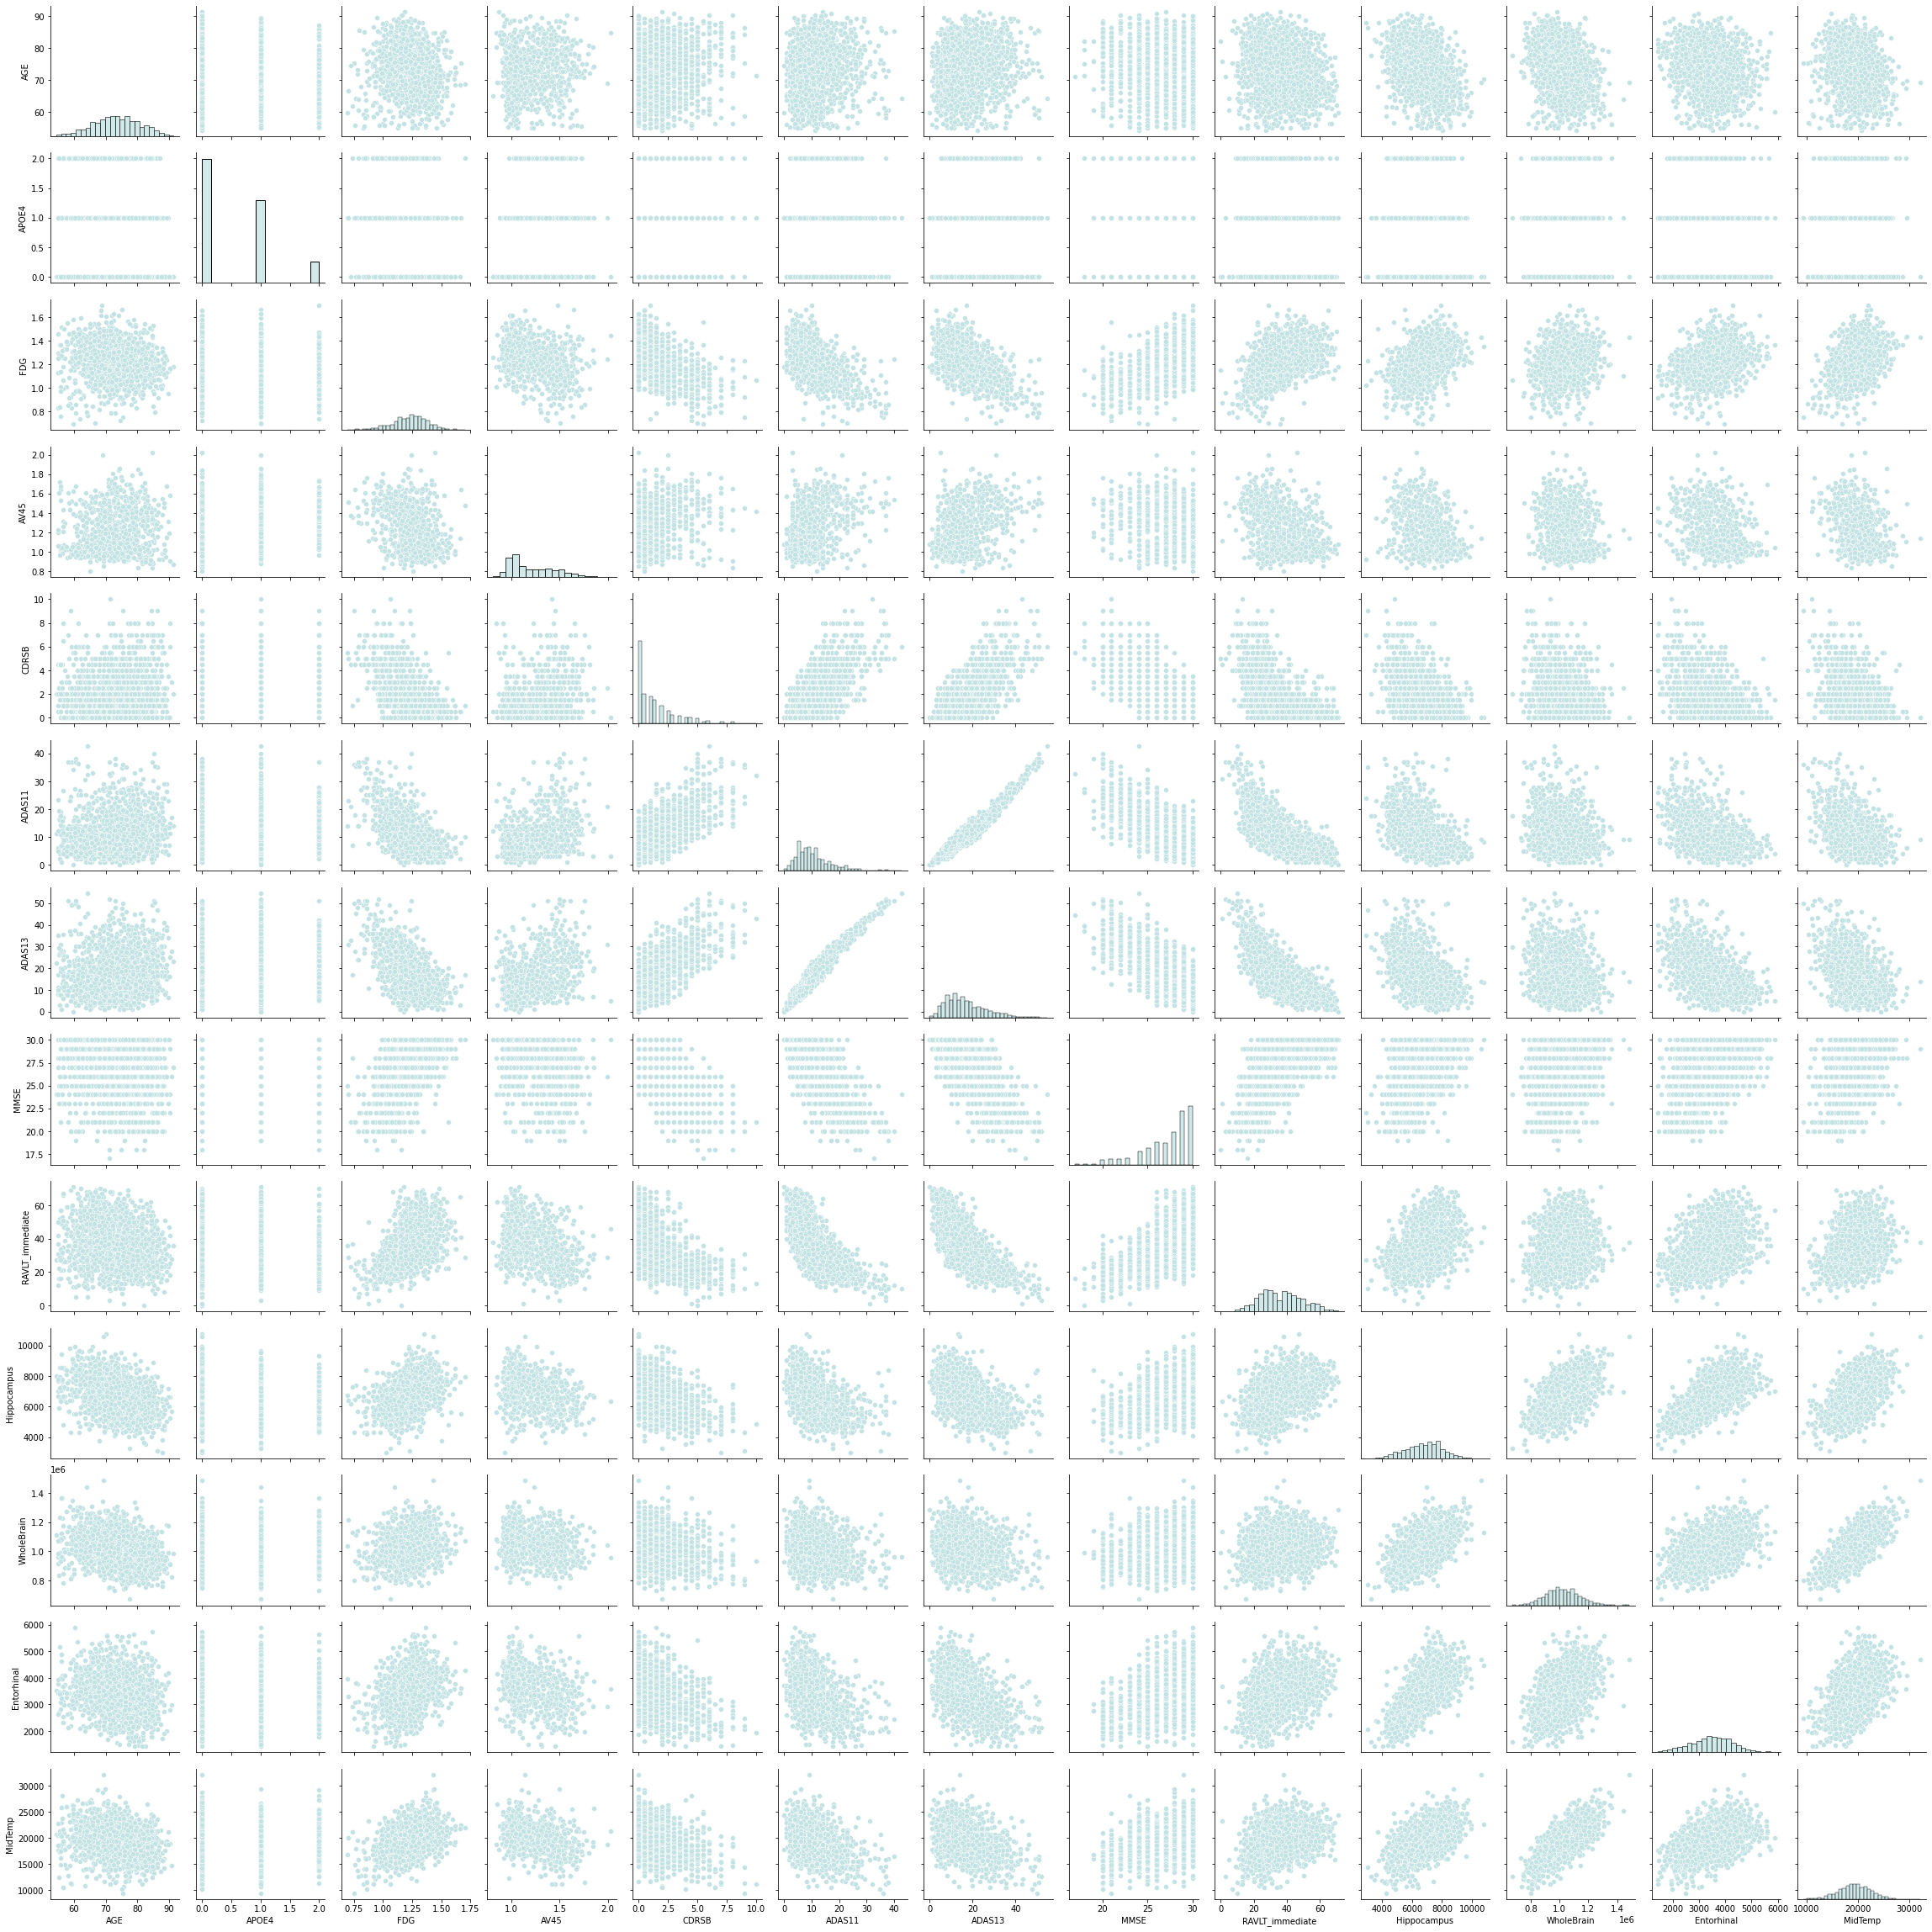

In [14]:
#Create a pairplot to visualize all the potential correlations in the dataset 
sns.pairplot(df);

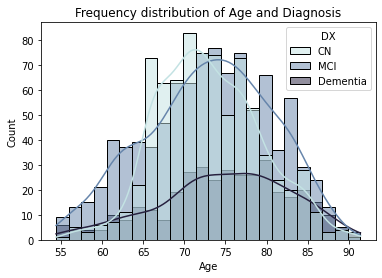

In [15]:
#Create a histogram that shows the distribution of Age and diagnosis in our dataset 
hue_order = ['CN','MCI', 'Dementia']
sns.histplot(data=df, x='AGE', hue='DX',kde=True, palette='ch:start=.2,rot=-.3', hue_order=hue_order).set(xlabel='Age', ylabel='Count')
plt.title('Frequency distribution of Age and Diagnosis');

In [16]:
# Get some statistics about the dataset 
df.describe()

,AGE,APOE4,FDG,AV45,CDRSB,ADAS11,ADAS13,MMSE,RAVLT_immediate,Hippocampus,WholeBrain,Entorhinal,MidTemp
count,2153.000000,2051.000000,1355.000000,1009.000000,2155.000000,2138.000000,2126.000000,2155.000000,2138.000000,1492.000000,1.692000e+03,1468.000000,1468.000000
mean,73.298421,0.550463,1.231578,1.204821,1.464269,10.810098,16.708518,27.389791,36.528531,6790.196381,1.021081e+06,3487.057902,19458.201635
std,7.230968,0.660941,0.152706,0.225811,1.761453,6.402462,9.268774,2.641763,12.837831,1185.271732,1.115228e+05,779.966989,3091.601296
min,54.400000,0.000000,0.693671,0.805364,0.000000,0.000000,0.000000,17.000000,0.000000,2991.000000,6.693640e+05,1426.000000,9375.000000
25%,68.300000,0.000000,1.141190,1.020030,0.000000,6.000000,10.000000,26.000000,27.000000,5948.000000,9.405800e+05,2951.000000,17485.000000
50%,73.300000,0.000000,1.242680,1.126540,1.000000,9.330000,15.000000,28.000000,36.000000,6864.000000,1.015730e+06,3508.500000,19418.500000
75%,78.400000,1.000000,1.332395,1.377340,2.000000,14.000000,22.000000,29.000000,46.000000,7651.250000,1.095870e+06,4040.500000,21525.250000
max,91.400000,2.000000,1.701130,2.025560,10.000000,42.670000,54.670000,30.000000,71.000000,10769.000000,1.486040e+06,5896.000000,32189.000000


So the mean age in our dataset is 73 years and the mean MMSE is 27.

In [17]:
# Let us find out how many unique values we have in each column 
df.nunique()

PTID               2155
AGE                 335
PTGENDER              2
APOE4                 3
FDG                1330
AV45               1004
ABETA               966
TAU                1111
PTAU               1114
CDRSB                18
ADAS11              103
ADAS13              140
MMSE                 14
RAVLT_immediate      69
Hippocampus        1265
WholeBrain         1669
Entorhinal         1159
MidTemp            1379
DX                    3
dtype: int64

In [18]:
#Count the total number of entries for the three different APOE4 expression levels 

df.groupby(['APOE4']).DX.count()

APOE4
0.0    1114
1.0     739
2.0     194
Name: DX, dtype: int64

In [19]:
#We create a new dataframe with the entries grouped by the Alzheimer stage 
df_apo=pd.pivot_table(df, index=['APOE4', 'DX'], values='PTID',aggfunc='count').reset_index()
df_apo

,APOE4,DX,PTID
0,0.0,CN,529
1,0.0,Dementia,119
2,0.0,MCI,466
3,1.0,CN,209
4,1.0,Dementia,167
5,1.0,MCI,363
6,2.0,CN,21
7,2.0,Dementia,71
8,2.0,MCI,102


In [20]:
#Create a list with the totals that we want to normalize the entries in the pivot to 
totals=[1114,1114,1114,739,739,739,194,194,194]

In [21]:
# Normalize entries in the list to the total number per APOE4 class 
df_apo['ratio']=(df_apo['PTID']/totals)*100
df_apo

,APOE4,DX,PTID,ratio
0,0.0,CN,529,47.486535
1,0.0,Dementia,119,10.682226
2,0.0,MCI,466,41.831239
3,1.0,CN,209,28.281461
4,1.0,Dementia,167,22.598106
5,1.0,MCI,363,49.120433
6,2.0,CN,21,10.824742
7,2.0,Dementia,71,36.597938
8,2.0,MCI,102,52.577320


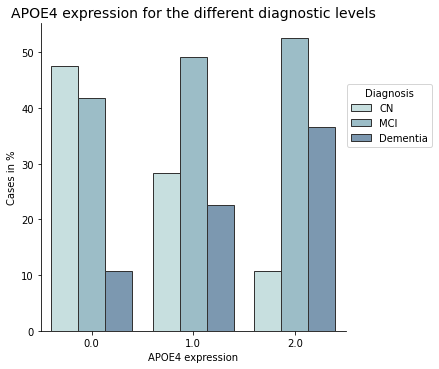

In [22]:
# So let us find out how diagnosis is correlated with the APOE4 gene expression. 
hue_order=['CN', 'MCI', 'Dementia'] 
sns.catplot(data=df_apo, kind='bar', x='APOE4', y='ratio', hue='DX', hue_order=hue_order, edgecolor=".2", legend=None).set(xlabel='APOE4 expression', ylabel='Cases in %')
plt.legend(title='Diagnosis', bbox_to_anchor=(1.3,0.7), loc='right')
plt.title('APOE4 expression for the different diagnostic levels', fontsize=14);

We see in this plot, that indeed the higher expression of APOE4 is associated with a higher number of patients diagnosed with mild cognitive impairment or dementia. In the next section, let us find out how the different brain parameters correlate with the diagnosis. 

In [23]:
df_brain=pd.pivot_table(df, index='DX', values=['Hippocampus', 'WholeBrain', 'Entorhinal', 'MidTemp'],aggfunc='mean').reset_index()


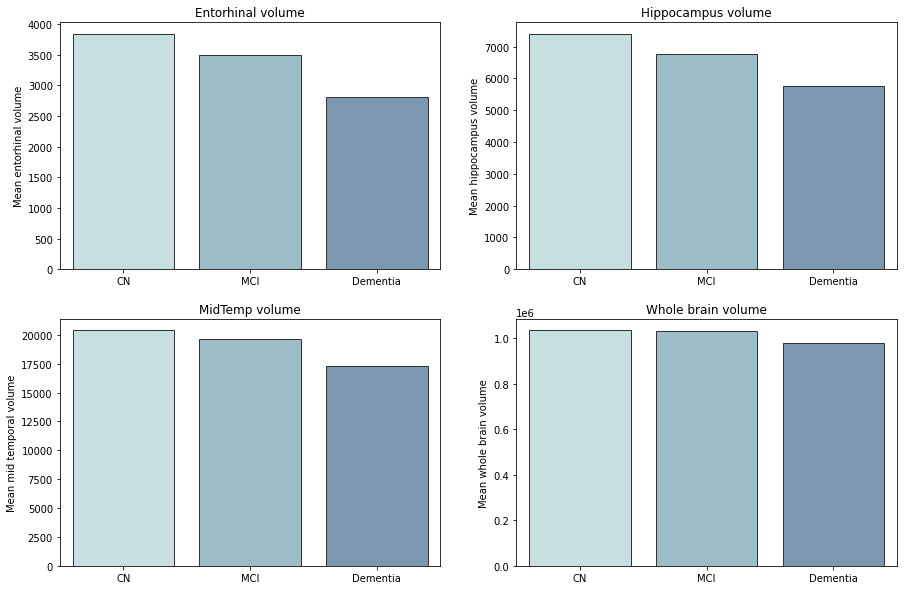

In [24]:
#Create plots with all four different categories 
fig, axes = plt.subplots(2,2, figsize=(15,10))

#Entorhinal
sns.barplot(ax=axes[0,0],data=df_brain, x='DX', y='Entorhinal', order=['CN', 'MCI', 'Dementia'], edgecolor=".2").set(xlabel=None, ylabel='Mean entorhinal volume')
axes[0,0].set_title('Entorhinal volume');

#Hippocampus 
sns.barplot(ax=axes[0,1],data=df_brain, x='DX', y='Hippocampus', order=['CN', 'MCI', 'Dementia'], edgecolor=".2").set(xlabel=None, ylabel='Mean hippocampus volume')
axes[0,1].set_title('Hippocampus volume');

#MidTemp 
sns.barplot(ax=axes[1,0],data=df_brain, x='DX', y='MidTemp', order=['CN', 'MCI', 'Dementia'], edgecolor=".2").set(xlabel=None, ylabel='Mean mid temporal volume')
axes[1,0].set_title('MidTemp volume');

#WholeBrain
sns.barplot(ax=axes[1,1],data=df_brain, x='DX', y='WholeBrain', order=['CN', 'MCI', 'Dementia'], edgecolor=".2").set(xlabel=None, ylabel='Mean whole brain volume')
axes[1,1].set_title('Whole brain volume');

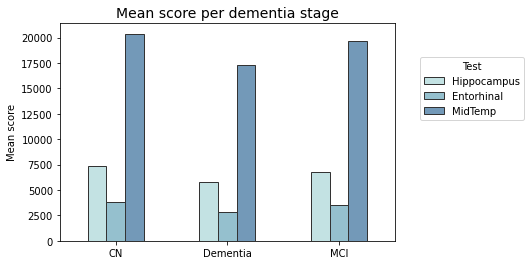

In [25]:
df_brain.plot(x='DX', y=['Hippocampus', 'Entorhinal', 'MidTemp'], kind='bar', edgecolor=".2").set(xlabel=None, ylabel='Mean score')
plt.legend(title='Test', bbox_to_anchor=(1.4,0.7), loc='right')
plt.title('Mean score per dementia stage', fontsize=14)
plt.xticks(rotation=0)
plt.show();

In [26]:
df_test=pd.pivot_table(df, index='DX', values=['MMSE', 'ADAS11', 'ADAS13', 'RAVLT_immediate'],aggfunc='mean').reset_index()
df_test
df_test=df_test.reindex([0,2,1])

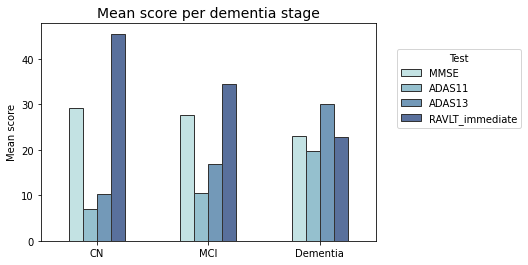

In [27]:
df_test.plot(x='DX', y=['MMSE', 'ADAS11', 'ADAS13', 'RAVLT_immediate'], kind='bar', edgecolor=".2").set(xlabel=None, ylabel='Mean score')
plt.legend(title='Test', bbox_to_anchor=(1.45,0.7), loc='right')
plt.title('Mean score per dementia stage', fontsize=14)
plt.xticks(rotation=0)
plt.show();


In [28]:
df.columns

Index(['PTID', 'AGE', 'PTGENDER', 'APOE4', 'FDG', 'AV45', 'ABETA', 'TAU',
       'PTAU', 'CDRSB', 'ADAS11', 'ADAS13', 'MMSE', 'RAVLT_immediate',
       'Hippocampus', 'WholeBrain', 'Entorhinal', 'MidTemp', 'DX'],
      dtype='object')

In [29]:
#Check if we only have every subject ones 
df.PTID.nunique()

2155

## 2. Modeling 

For the numeric data we start with some very simple basic machine learning models and see how they perform. We need to also scale the numeric values to have them in a similar range. 

In [30]:
#Since we will get problems with the NaN values, we just start with dropping all NaN values. If this leads to bad modelling we can change this later. 
df.dropna(axis=0, inplace=True)

#drop the column with the IDs and strange symbols
df.drop(columns=df[['PTID','ABETA','PTAU']], inplace=True)

/Users/tamarapallien/.pyenv/versions/3.9.8/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/Users/tamarapallien/.pyenv/versions/3.9.8/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [31]:
#Convert everything to numerical values 
df[['TAU']].astype(float)

,TAU
76,101.20
77,170.40
127,347.80
159,324.80
428,108.20
...,...
13086,279.90
13090,314.60
13093,305.00
13098,300.10


In [32]:
df.head(2)

,AGE,PTGENDER,APOE4,FDG,AV45,TAU,CDRSB,ADAS11,ADAS13,MMSE,RAVLT_immediate,Hippocampus,WholeBrain,Entorhinal,MidTemp,DX
76,67.5,Male,0.0,1.25096,0.983143,101.2,0.0,3.0,5.0,30.0,42.0,8297.0,1165500.0,4946.0,21194.0,CN
77,68.5,Male,0.0,1.49677,0.985156,170.4,0.0,4.0,7.0,30.0,61.0,7654.0,1081140.0,4065.0,18611.0,CN


In [33]:
# Use get_dummies for the PTGENDER and APOE4 column 
df=pd.get_dummies(df, columns=['PTGENDER', 'APOE4'], drop_first=False)


In [34]:
#Train-test-split 
X=df.drop('DX', axis=1)
y=df['DX']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify =y, random_state=42)

In [35]:
print(X_test.shape)
print(X_train.shape)

(161, 18)
(480, 18)


In [36]:
#Use Standard Scaler for the numeric data 
scaler = StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.fit_transform(X_test)

In [69]:
# setting the MLFlow connection and experiment
mlflow.start_run(run_name='2_log_reg_scaled')
run = mlflow.active_run()

### 1. Logistic Regression 


In [70]:
#Run a simple logistic regression model 

log_reg=LogisticRegression(max_iter=1000)
log_reg.fit(X_train_scaled, y_train)

y_pred_train=log_reg.predict(X_train)
y_pred=log_reg.predict(X_test_scaled)

/Users/tamarapallien/.pyenv/versions/3.9.8/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [71]:
y_train

8437         MCI
8670          CN
8677    Dementia
3080         MCI
3032         MCI
          ...   
6719         MCI
3444         MCI
4035         MCI
5455         MCI
5439         MCI
Name: DX, Length: 480, dtype: object

In [72]:
# Check out the metrics
acc_test = accuracy_score(y_test, y_pred)
print(acc_test)
acc_train=accuracy_score(y_train, log_reg.predict(X_train_scaled))

0.8757763975155279


accuracy:  0.88


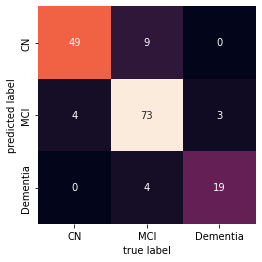

In [73]:
# Plotting the confusing matrix
labels=['CN', 'MCI', 'Dementia']
mat = confusion_matrix(y_test, y_pred, labels=labels)
cm=sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
cm.set_xticklabels(labels)
cm.set_yticklabels(labels)
plt.xlabel('true label')
plt.ylabel('predicted label')
print('accuracy: ' , accuracy_score(y_test, y_pred).round(2))
#print('recall: ' , recall_score(y_test, y_pred).round(2))
#print('precision: ' , precision_score(y_test, y_pred).round(2))

In [74]:
#logging metrics
mlflow.log_metric("train-" + "accuracy", acc_train)
mlflow.log_metric("test-" + "accuracy", acc_test)

# mlflow.sklearn.log_model(reg, "model")
mlflow.end_run()

mlflow.get_run(run_id=run.info.run_id)

<Run: data=<RunData: metrics={'test-accuracy': 0.8757763975155279, 'train-accuracy': 0.9458333333333333}, params={}, tags={'mlflow.runName': '2_log_reg_scaled',
 'mlflow.source.name': '/Users/tamarapallien/.pyenv/versions/3.9.8/lib/python3.9/site-packages/ipykernel_launcher.py',
 'mlflow.source.type': 'LOCAL',
 'mlflow.user': 'tamarapallien'}>, info=<RunInfo: artifact_uri='s3://neuefische-mlflow/mlflow-artifacts/56/fbee0a0de73b4c11a64c86da6ff5c8e5/artifacts', end_time=1661505359328, experiment_id='56', lifecycle_stage='active', run_id='fbee0a0de73b4c11a64c86da6ff5c8e5', run_uuid='fbee0a0de73b4c11a64c86da6ff5c8e5', start_time=1661505358427, status='FINISHED', user_id='tamarapallien'>>